In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.environ['rapp'])
from rayleigh_diagnostics import Point_Probes
from reference_tools import equation_coefficients
sys.path

['/home1/lmatilsk/rayleigh/utils/test_equations',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python37.zip',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python3.7',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python3.7/lib-dynload',
 '',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python3.7/site-packages',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python3.7/site-packages/IPython/extensions',
 '/home1/lmatilsk/.ipython',
 '/home1/lmatilsk/rayleigh/code/post_processing']

In [2]:
dirnumber = 4
savefig = True
savedir = '/home1/lmatilsk/equation_test_figs/'
    
if dirnumber == 3:  
    dirname = '/nobackup/lmatilsk/benchmarks/j2011_mhd/00_test_equations_1k_iter/'
    advect_ref = False
    mag = True
    dirtag = 'j2011_mhd_orig'
    
if dirnumber == 4:
    dirname = '/nobackup/lmatilsk/case_M-Prm4.0/00_1k_iters_nt384_orig/'
    advect_ref = True
    mag = True
    dirtag = 'case_M_nt384_orig'
    
if dirnumber == 5:
    dirname = '/nobackup/lmatilsk/case_M-Prm4.0/00_1k_iters_nt384_dealiasby2/'
    advect_ref = True
    mag = True
    dirtag = 'case_M_nt384_dealiasby2'
    
if dirnumber == 6:
    dirname = '/nobackup/lmatilsk/case_M-Prm4.0/00_1k_iters_nt768/'
    advect_ref = True
    mag = True
    dirtag = 'case_M_768'
    
if dirnumber == 7:
    dirname = '/nobackup/lmatilsk/case_M-Prm4.0/00_1k_iters_nt768_dealiasby2/'
    advect_ref = True
    mag = True
    dirtag = 'case_M_nt768_dealiasby2'

In [3]:
radatadir = dirname + 'Point_Probes/'
the_file = radatadir + os.listdir(radatadir)[0]
pp = Point_Probes(the_file,'')
print(the_file)

/nobackup/lmatilsk/case_M-Prm4.0/00_1k_iters_nt384_orig/Point_Probes/24901000


In [4]:
# break up point probes data
vals = pp.vals

times =  pp.time
dt = times[2:] - times[1:-1]
dt = dt.reshape((1, 1, 1, len(dt)))
dt_old = times[1:-1] - times[:-2]
dt_old = dt_old.reshape((1, 1, 1, len(dt_old)))

lut = pp.lut
irvals = pp.rad_inds
ithetavals = pp.theta_inds
iphivals = pp.phi_inds

print ('iphivals = ', iphivals)
print ('ithetavals = ', ithetavals)
print ('irvals = ', irvals)

iphivals =  [  0  96 192 288 384 479 575 671]
ithetavals =  [ 19  48  96 144 191 239 287 335 364]
irvals =  [  9  14  21  26  31  37  42  49  54  63  84  98 136 146 154 160 167 175
 181]


In [5]:
print (np.shape(vals))

(8, 9, 19, 80, 1000)


In [6]:
# pick a point
iphi0, it0, ir0 = 5, 0, 14

In [7]:
# get rotation period (for time axis)
eq = equation_coefficients()
eq.read(dirname + 'equation_coefficients')
Om0 = eq.constants[0]/2
prot = 2*np.pi/Om0
t = times/prot

In [8]:
# check if timestep changes (usually doesn't over 1000 iters)
print(np.mean(np.diff(times)))
print(np.std(np.diff(times)))
print (len(times))

228.72198867797852
0.0
1000


In [9]:
# get maxabs of multiple multi dimensional arrays (keeps the dimensions intact)
def my_maxabs(*args):
    the_shape = np.shape(args[0])
    maxabs = np.zeros(the_shape) - np.inf
    for arg in args:
        maxabs = np.maximum(maxabs, np.abs(arg))
    return maxabs

In [10]:
# r induct
b_r = vals[..., lut[801], :]

shear_r = vals[..., lut[1601], :]
comp_r = vals[..., lut[1602], :]
adv_r = vals[..., lut[1603], :]
fexp_r = induct_r = vals[..., lut[1604], :]

fimp_r = diff_r = vals[..., lut[1605], :]

# max abs (to normalize later)
maxabs_r = my_maxabs(shear_r, comp_r, adv_r, induct_r, diff_r)

In [11]:
# theta induct
b_t = vals[..., lut[802], :]

shear_t = vals[..., lut[1606], :]
comp_t = vals[..., lut[1607], :]
adv_t = vals[..., lut[1608], :]
fexp_t = induct_t = vals[..., lut[1609], :]

fimp_t = diff_t = vals[..., lut[1610], :]

# max abs (to normalize later)
maxabs_t = my_maxabs(shear_t, comp_t, adv_t, induct_t, diff_t)

In [12]:
# phi induct
b_p = vals[..., lut[803], :]

shear_p = vals[..., lut[1611], :]
comp_p = vals[..., lut[1612], :]
adv_p = vals[..., lut[1613], :]
fexp_p = induct_p = vals[..., lut[1614], :]

fimp_p = diff_p = vals[..., lut[1615], :]

# max abs (to normalize later)
maxabs_p = my_maxabs(shear_p, comp_p, adv_p, induct_p, diff_p)

In [13]:
# get lhs = d var / dt
def get_ddt(variable):
    dvar = variable[..., 2:] - variable[..., 1:-1]
    return dvar/dt

dbdt_r = get_ddt(b_r)
dbdt_t = get_ddt(b_t)
dbdt_p = get_ddt(b_p)

In [14]:
# get weighted rhs

def get_weighted_rhs(fimp, fexp):
    return 0.5*(fimp[..., 2:] + fimp[..., 1:-1]) + fexp[..., 1:-1] +\
        0.5*(dt/dt_old)*(fexp[..., 1:-1] - fexp[..., :-2])

fweighted_r = get_weighted_rhs(fimp_r, fexp_r)
fweighted_t = get_weighted_rhs(fimp_t, fexp_t)
fweighted_p = get_weighted_rhs(fimp_p, fexp_p)

Text(0.5, 1.0, 'induct (r)')

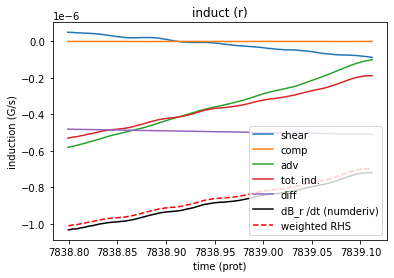

In [15]:
# plot r induct(all pieces)

# pieces
plt.plot(t, shear_r[iphi0, it0, ir0, :], label='shear')
plt.plot(t, comp_r[iphi0, it0, ir0, :], label='comp')
plt.plot(t, adv_r[iphi0, it0, ir0, :], label='adv')
plt.plot(t, induct_r[iphi0, it0, ir0, :], label='tot. ind.')
plt.plot(t, diff_r[iphi0, it0, ir0, :], label='diff')

# totals
plt.plot(t[2:], dbdt_r[iphi0, it0, ir0, :], 'k', label='dB_r /dt (numderiv)')
plt.plot(t[2:], fweighted_r[iphi0, it0, ir0, :], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('induction (G/s)')
plt.title('induct (r)')

Text(0.5, 1.0, 'induct totals (r)')

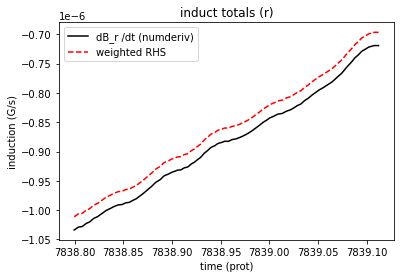

In [16]:
# plot r induct (totals)
plt.plot(t[2:], dbdt_r[iphi0, it0, ir0, :], 'k', label='dB_r /dt (numderiv)')
plt.plot(t[2:], fweighted_r[iphi0, it0, ir0, :], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('induction (G/s)')
plt.title('induct totals (r)')

Text(0.5, 1.0, 'induct (t)')

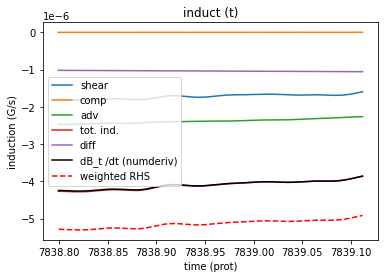

In [17]:
# plot theta induct(all pieces)

# pieces
plt.plot(t, shear_t[iphi0, it0, ir0, :], label='shear')
plt.plot(t, comp_t[iphi0, it0, ir0, :], label='comp')
plt.plot(t, adv_t[iphi0, it0, ir0, :], label='adv')
plt.plot(t, induct_t[iphi0, it0, ir0, :], label='tot. ind.')
plt.plot(t, diff_t[iphi0, it0, ir0, :], label='diff')

# totals
plt.plot(t[2:], dbdt_t[iphi0, it0, ir0, :], 'k', label='dB_t /dt (numderiv)')
plt.plot(t[2:], fweighted_t[iphi0, it0, ir0, :], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('induction (G/s)')
plt.title('induct (t)')

Text(0.5, 1.0, 'induct totals (t)')

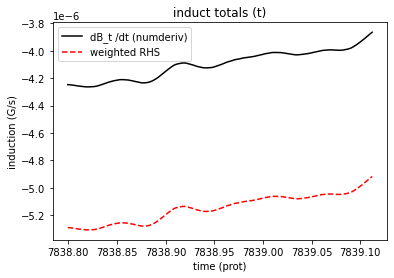

In [18]:
# plot theta induct (totals)
plt.plot(t[2:], dbdt_t[iphi0, it0, ir0, :], 'k', label='dB_t /dt (numderiv)')
plt.plot(t[2:], fweighted_t[iphi0, it0, ir0, :], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('induction (G/s)')
plt.title('induct totals (t)')

Text(0.5, 1.0, 'induct (p)')

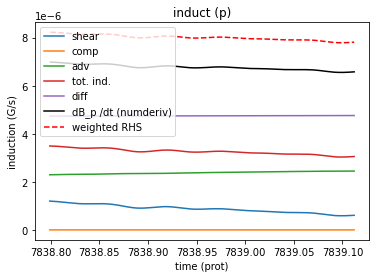

In [19]:
# plot phi induct (all pieces)

# pieces
plt.plot(t, shear_p[iphi0, it0, ir0, :], label='shear')
plt.plot(t, comp_p[iphi0, it0, ir0, :], label='comp')
plt.plot(t, adv_p[iphi0, it0, ir0, :], label='adv')
plt.plot(t, induct_p[iphi0, it0, ir0, :], label='tot. ind.')
plt.plot(t, diff_p[iphi0, it0, ir0, :], label='diff')

# totals
plt.plot(t[2:], dbdt_p[iphi0, it0, ir0, :], 'k', label='dB_p /dt (numderiv)')
plt.plot(t[2:], fweighted_p[iphi0, it0, ir0, :], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('induction (G/s)')
plt.title('induct (p)')

Text(0.5, 1.0, 'induct totals (p)')

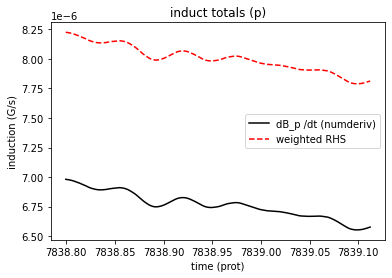

In [20]:
# plot phi induct (totals)
plt.plot(t[2:], dbdt_p[iphi0, it0, ir0, :], 'k', label='dB_p /dt (numderiv)')
plt.plot(t[2:], fweighted_p[iphi0, it0, ir0, :], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('induction (G/s)')
plt.title('induct totals (p)')

In [21]:
# quantify the numerical errors
def get_err(diff, norm, point=None, ir=None, itheta=None, iphi=None):
    if not point is None:
        iphi, itheta, ir = point
    
    # make everything an array
    if np.isscalar(iphi):
        iphi = np.array([iphi])
    if np.isscalar(itheta):
        itheta = np.array([itheta])
    if np.isscalar(ir):
        ir = np.array([ir])
        
    nphi, ntheta, nr, ntimes = np.shape(diff)
    if iphi is None: # all indices, default
        iphi = np.arange(nphi)
    if itheta is None: # all indices, default
        itheta = np.arange(ntheta)
    if ir is None: # all indices, default
        ir = np.arange(nr)        

    # compute rms via for loop, weight all points (including times) equally
    numer = 0.0
    denom = 0.0
    count = 0
    for iphi_loc in iphi:
        for itheta_loc in itheta:
            for ir_loc in ir:
                for it_loc in range(ntimes):
                    numer += diff[iphi_loc, itheta_loc, ir_loc, it_loc]**2
                    denom += norm[iphi_loc, itheta_loc, ir_loc, it_loc]**2
                    count += 1
    numer /= count
    denom /= count # not that this matters...
    return np.sqrt(numer)/np.sqrt(denom)

In [22]:
# stringent error, at the point we plotted
print ("err induct r = ", get_err(fweighted_r - dbdt_r, fweighted_r, point=(iphi0, it0, ir0)))
print ("err induct t = ", get_err(fweighted_t - dbdt_t, fweighted_t, point=(iphi0, it0, ir0)))
print ("err induct p = ", get_err(fweighted_p - dbdt_p, fweighted_p, point=(iphi0, it0, ir0)))

err induct r =  0.0260889245713557
err induct t =  0.20346419563943138
err induct p =  0.15492094018643043


In [23]:
# errors (w.r.t. maxabs) at the point we plotted
print ("err induct r = ", get_err(fweighted_r - dbdt_r, maxabs_r[2:], point=(iphi0, it0, ir0)))
print ("err induct t = ", get_err(fweighted_t - dbdt_t, maxabs_t[2:], point=(iphi0, it0, ir0)))
print ("err induct p = ", get_err(fweighted_p - dbdt_p, maxabs_p[2:], point=(iphi0, it0, ir0)))

err induct r =  0.009374051710621677
err induct t =  0.4080193183973785
err induct p =  0.3023304760644201


In [24]:
# stringent errors over whole shell
print ("err induct r = ", get_err(fweighted_r - dbdt_r, fweighted_r))
print ("err induct t = ", get_err(fweighted_t - dbdt_t, fweighted_t))
print ("err induct p = ", get_err(fweighted_p - dbdt_p, fweighted_p))

err induct r =  0.2709049889787209
err induct t =  0.8675585754808828
err induct p =  0.9464739663167454


In [25]:
# errors over whole shell (w.r.t. maxabs)
print ("err induct r = ", get_err(fweighted_r - dbdt_r, maxabs_r[..., 2:]))
print ("err induct t = ", get_err(fweighted_t - dbdt_t, maxabs_t[..., 2:]))
print ("err induct p = ", get_err(fweighted_p - dbdt_p, maxabs_p[..., 2:]))

err induct r =  0.24076768814176921
err induct t =  0.8174535556531677
err induct p =  0.8999111751759586


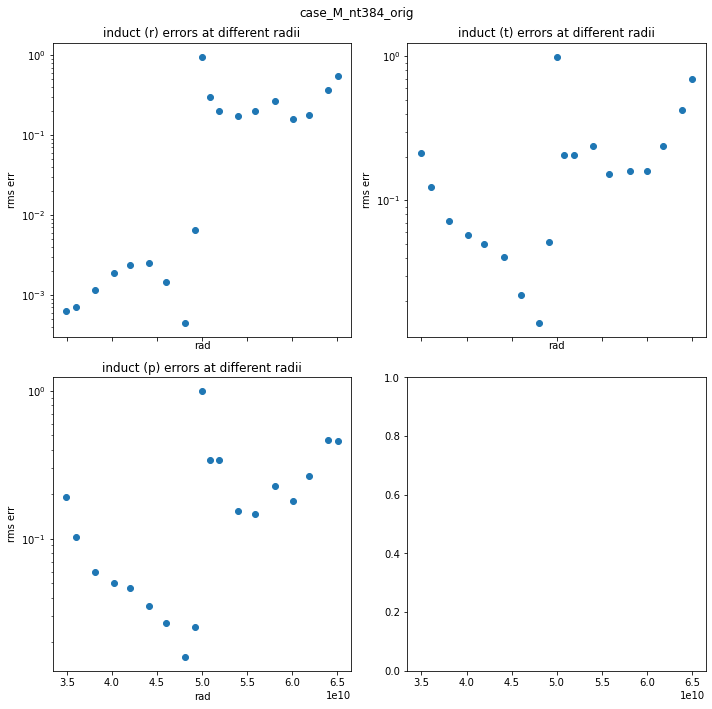

In [26]:
# stringent error at each radius, averaged horizontally, for each equation
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(10,10))
count = 0
for irow in range(2):
    for icol in range(2):
        if count == 0:
            diff = fweighted_r - dbdt_r
            fweighted = fweighted_r
            label= 'induct (r)'
        if count == 1:
            diff = fweighted_t - dbdt_t
            fweighted = fweighted_t
            label= 'induct (t)'
        if count == 2:
            diff = fweighted_p - dbdt_p
            fweighted = fweighted_p
            label= 'induct (p)'
        if count == 3:
            continue
            
        errs = []
        for i in range(len(irvals)):
            #print ('ir = %i:' %i, 'err = ', get_err(fweighted_r - drhovdt_r, fweighted_r, ir=i))
            errs.append(get_err(diff, fweighted, ir=i))

        plt.sca(axs[irow, icol])
        plt.scatter(pp.radius, errs)
        plt.xlabel('rad')
        plt.ylabel('rms err')
        plt.yscale('log')
        plt.title(label + ' errors at different radii')
        count += 1
plt.suptitle(dirtag)
plt.tight_layout()

if savefig:
    plt.savefig(savedir + 'induct_' + dirtag + '.pdf')

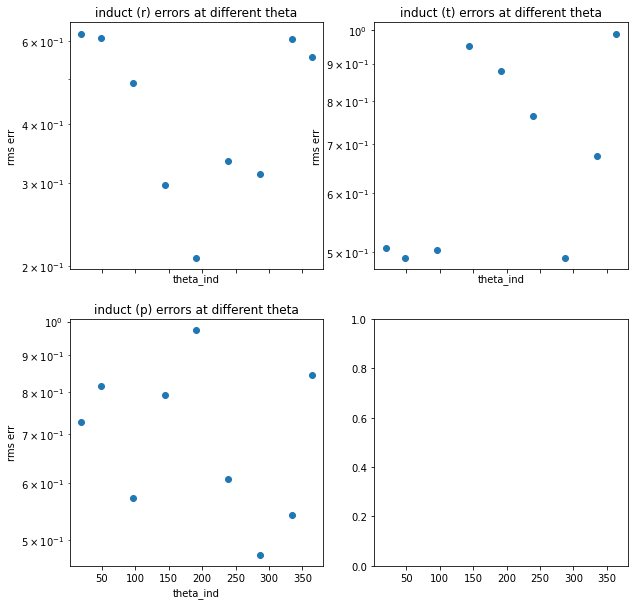

In [27]:
# stringent error at each theta, averaged in r and phi
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(10,10))
count = 0
for irow in range(2):
    for icol in range(2):
        if count == 0:
            diff = fweighted_r - dbdt_r
            fweighted = fweighted_r
            label= 'induct (r)'
        if count == 1:
            diff = fweighted_t - dbdt_t
            fweighted = fweighted_t
            label= 'induct (t)'
        if count == 2:
            diff = fweighted_p - dbdt_p
            fweighted = fweighted_p
            label = 'induct (p)'
        if count == 3:
            continue
            
        errs = []
        for i in range(len(ithetavals)):
            #print ('ir = %i:' %i, 'err = ', get_err(fweighted_r - drhovdt_r, fweighted_r, ir=i))
            errs.append(get_err(diff, fweighted, itheta=i))

        plt.sca(axs[irow, icol])
        plt.scatter(ithetavals, errs)
        plt.xlabel('theta_ind')
        plt.ylabel('rms err')
        plt.yscale('log')
        plt.title(label + ' errors at different theta')
        count += 1

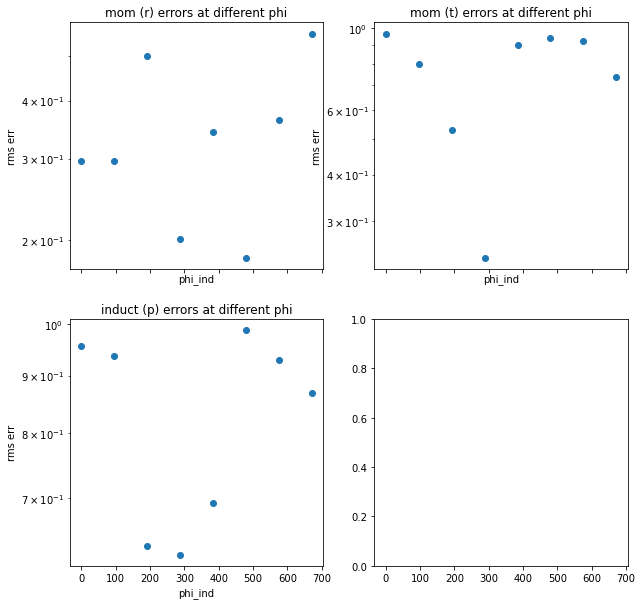

In [28]:
# stringent error at each phi, averaged in meridional planes
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(10,10))
count = 0
for irow in range(2):
    for icol in range(2):
        if count == 0:
            diff = fweighted_r - dbdt_r
            fweighted = fweighted_r
            label= 'induct (r)'
        if count == 1:
            diff = fweighted_t - dbdt_t
            fweighted = fweighted_t
            label= 'induct (t)'
        if count == 2:
            diff = fweighted_p - dbdt_p
            fweighted = fweighted_p
            label= 'induct (p)'
        if count == 3:
            continue
            
        errs = []
        for i in range(len(iphivals)):
            #print ('ir = %i:' %i, 'err = ', get_err(fweighted_r - drhovdt_r, fweighted_r, ir=i))
            errs.append(get_err(diff, fweighted, iphi=i))

        plt.sca(axs[irow, icol])
        plt.scatter(iphivals, errs)
        plt.xlabel('phi_ind')
        plt.ylabel('rms err')
        plt.yscale('log')
        plt.title(label + ' errors at different phi')
        count += 1